In [49]:
### imports ###
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import math

print("PyTorch version: %s" % torch.__version__)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: %s" % dev)

PyTorch version: 1.4.0
Using device: cuda


In [50]:
# load processed data
(x, y, index, delta_time, districts) = np.load('processed/loc_data.npy', allow_pickle=True)

In [104]:
samples = 3
R_0 = 2.6
clean_interval = 3

K = np.zeros((samples, districts, delta_time), dtype=int) # infected bikes at position at time
K_leave = np.zeros(districts, dtype=int) # bikes leaving
K_coming = np.zeros(districts, dtype=int) # bikes leaving
K[0:samples, 770:780, 0] = 1
#P = np.zeros(districts).astype(int) # population

for s in range(samples):
    
    for t in range(delta_time-1):
    
        #(i,j,TT) = np.load('processed/T_{}.npy'.format(t), allow_pickle=True)
        T = np.load('processed/T_full_{}.npy'.format(t), allow_pickle=True)
        N = T.sum(0) # number of traveller away from j
        idx = np.where(N > 0)[0] # all relevant j values
        for ids in idx: # ids is relevant j value
            dest = T[:,ids] # number of bikes going to i for ids = j
            idl = np.array(np.where(dest > 0)[0]) # which indices i do bikes go to
            dz = np.array(dest[idl]).astype(int) # frequency of bikes to destination
            bag_of_i = np.repeat(idl.reshape(len(idl), 1), dz)
            p_unnorm = np.repeat(dz.reshape(len(dz), 1), dz)
            #print(p_unnorm)
            #print(bag_of_i)
            tot_bikes = bag_of_i.shape[0]
        
            if I[ids] < tot_bikes:
                pick_t = np.random.choice(bag_of_i, I[ids], replace=False, p=p_unnorm/p_unnorm.sum())
            else:
                pick_t = bag_of_i
            # pick_t gets all i desinations of infected bikes
            #print(pick_t)
            
            K_leave[ids] = pick_t.shape[0]
            for i in pick_t:
                K_coming[i] += 1
            
            #print(K_leave[ids])
            #print(K_coming[ids])
    
        # update
        #print(K_coming)
        if t % clean_interval == 0:
            gate = 0
        else:
            gate = 1
        
        K[s, :, t+1] = R_0 * gate * (K[s, :, t] - K_leave[:]) + K_coming[:]
        K_leave.fill(0)
        K_coming.fill(0)
    print('Sample {}'.format(s))

Sample 0
Sample 1
Sample 2


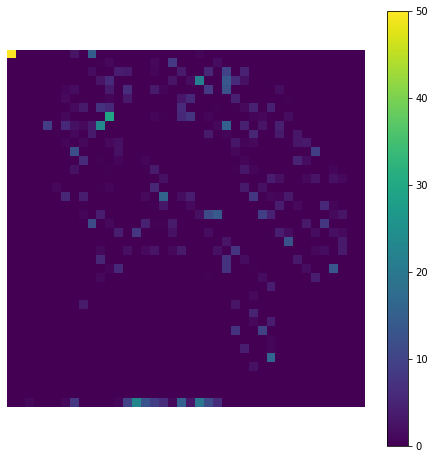

In [115]:
import matplotlib.animation as animation
from IPython.display import HTML
# group_x + bins*group_y is the index

bins = int(math.sqrt(districts))
fig = plt.figure(figsize=(8,8))
plt.axis("off")
K_m = K.mean(0)
K_m[0, :] = 100
K_sd = K.std(0)
K_m_sq = np.zeros((bins, bins, delta_time))
for gx in range(bins):
    for gy in range(bins):
        K_m_sq[gx, gy, :] = K_m[gx + gy*bins, :]

ims = [[plt.imshow(K_m_sq[:,:,t], animated=True, vmin=0, vmax=50)] for t in range(delta_time)]
plt.colorbar()
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())



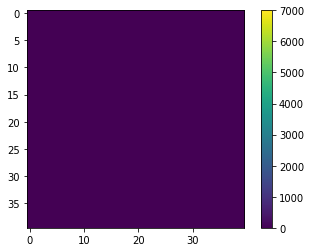

In [112]:
ims = [[plt.imshow(K_sd[:,t].reshape(bins, bins), animated=True, vmin=0, vmax=7000)] for t in range(delta_time)]
K_sd_sq = np.zeros((bins, bins, delta_time))
for gx in range(bins):
    for gy in range(bins):
        K_sd_sq[gx, gy, :] = K_m[gx + gy*bins, :]
plt.colorbar()
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [55]:
len(idl)

2

In [20]:
np.repeat(g, [1, 2, 3])

array([0, 5, 5, 4, 4, 4])

In [35]:
pick_t = np.asarray(range(5))

In [111]:
import geopandas